# Lipschitz-Bounded Deep Networks for MNIST

This notebook is a work-in-progress. The plan is to write a tutorial for L4DC 2025 which demonstrates how to set up and train Lipschitz-Bounded Deep Networks (LBDNs).

The rough outline will be:

- Load the dataset.
- Set up a regular MLP.
- Set up an LBDN.
- Train both models.
- Verify robustness of both models via adversarial attacks.

It would be great if we can make this notebook runnable on google colab. That way we can actually use the GPU too. The downside is going to be dependencies, since this repository is not yet public and, even when it is, the pacakge needs to be downloaded and installed locally. Let's see what we can do.

This notebook is based on the [Flax MNIST tutorial](https://flax.readthedocs.io/en/latest/mnist_tutorial.html).

## Enable the GPU

This notebook runs a lot faster on a GPU compared to the CPU. To enable GPU usage, simply:

- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

## Import Packages

In [1]:
# Clean installation of the robust neural networks package and code
!rm -rf RobustNeuralNetworks/
!git clone -b l4dc25 https://github.com/nic-barbara/RobustNeuralNetworks
!pip install RobustNeuralNetworks/

## Install standard Python packages
import warnings
warnings.filterwarnings('ignore')

# For setting up and training models
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
from functools import partial

# Data handling
import tensorflow_datasets as tfds
import tensorflow as tf

# Plotting and analysis
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from pathlib import Path

# Custom libraries
from robustnn import lbdn

Cloning into 'RobustNeuralNetworks'...
remote: Enumerating objects: 1682, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 1682 (delta 250), reused 242 (delta 216), pack-reused 1247 (from 1)
Receiving objects: 100% (1682/1682), 62.97 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (1086/1086), done.
Processing ./RobustNeuralNetworks
  Preparing metadata (setup.py) ... done
  Created wheel for robustnn: filename=robustnn-0.0.0-py3-none-any.whl size=29935 sha256=95a31cafc65a697a927be885631ed81292571b20d7d90086eb1151f8d61872d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-fv0mxde4/wheels/f4/1e/7e/e6fd055fe7447929be5ce28851bb34bdf0243130b8ff4acd16
Successfully built robustnn
  Attempting uninstall: robustnn
    Found existing installation: robustnn 0.0.0
    Uninstalling robustnn-0.0.0:
      Successfully uninstalled robustnn-0.0.0


In [2]:
# Custom plot formatting to make things look pretty
def startup_plotting(font_size=14, line_width=1.5, output_dpi=600, tex_backend=True):
    """Edited from https://github.com/nackjaylor/formatting_tips-tricks/"""

    # Default settings
    plt.rcParams.update({
        "lines.linewidth": line_width,

        "axes.grid" : True,
        "axes.grid.which": "major",
        "axes.linewidth": 0.5,
        "axes.prop_cycle": cycler("color", [
            "#0072B2", "#E69F00", "#009E73", "#CC79A7",
            "#56B4E9", "#D55E00", "#F0E442", "#000000"]),

        "errorbar.capsize": 2.5,

        "grid.linewidth": 0.25,
        "grid.alpha": 0.5,

        "legend.framealpha": 0.7,
        "legend.edgecolor": [1,1,1],

        "savefig.dpi": output_dpi,
        "savefig.format": 'pdf'
    })

    # Change default font sizes.
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size)
    plt.rc('axes', labelsize=font_size)
    plt.rc('xtick', labelsize=0.8*font_size)
    plt.rc('ytick', labelsize=0.8*font_size)
    plt.rc('legend', fontsize=0.8*font_size)

startup_plotting()

## 0. Setting Up

Set random seed for reproducibility.

In [3]:
seed = 42
tf.random.set_seed(seed)

Decide how we'll split up our training and test data. These are effectively hyperparameters for the training later on too.

In [4]:
train_steps = 2400      # Number of training steps to take
eval_every = 100        # How often to evaluate during training
batch_size = 64         # Training batch size
test_batch_size = 256   # Test batch size

Some useful file paths.

In [5]:
dirpath = Path(__name__).resolve().parent
datapath = dirpath / "../data/"
filepath = dirpath / "results/mnist/"
if not filepath.exists():
    filepath.mkdir(parents=True)

## 1. Loading the MNIST Dataset

Load the dataset

In [6]:
train_ds: tf.data.Dataset = tfds.load('mnist', split='train', data_dir=datapath)
test_ds: tf.data.Dataset = tfds.load('mnist', split='test', data_dir=datapath)

Pre-process the data. The images in the MNIST dataset are numbered 0-9 (inclusive) and are $28\times28$ pixels. We're using MLPs for this example (just for simplicity) so we'll squash all the 2D images into vectors. The following code:
1. Flattens the images into $28^2$-element vectors.
2. Normalises the data so that all pixel values are between 0 and 1.


In [7]:
def flatten_and_normalise(sample):
    image = sample["image"]
    label = sample["label"]
    image = tf.cast(image, tf.float32) / 255
    image = tf.reshape(image, [-1])
    return {"image": image, "label": label}

# Process data
train_ds = train_ds.map(flatten_and_normalise)
test_ds = test_ds.map(flatten_and_normalise)

# Store sizes for later
n_inputs = 28 * 28      # Images are 28 x 28 pixels each
n_out = 10              # Numbers are 0 to 9, so 10 options

To put the data in a nice format for training and evaluation, we need to sort the data into batches and shuffle the order of the batches so there's no accidental bias during training.

In [8]:
train_ds = train_ds.repeat().shuffle(1024, seed=seed)
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
test_ds = test_ds.batch(test_batch_size, drop_remainder=True).prefetch(1)

## 2. Define a Model

A standard way to define a Multi-Layer Perceptron (MLP) in Flax is as follows.

In [9]:
class MLP(nn.Module):
    """A simple MLP model."""

    def setup(self):
      self.linear1 = nn.Dense(64)
      self.linear2 = nn.Dense(64)
      self.linear3 = nn.Dense(n_out)

    def __call__(self, x):
        x = nn.relu(self.linear1(x))
        x = nn.relu(self.linear2(x))
        x = self.linear3(x)
        return x

With our package, we can create Lipschitz-bounded models with very similar code! The main differences are as follows:
- We use the 1-Lipschitz `SandwichLayer` rather than the standard `Dense` layer.
- Activation functions are included directly in the `SandwichLayer` and don't need to be applied externally.
- To enforce a Lipschitz upper-bound of $\gamma$, we multiply both the network inputs and outputs by $\sqrt{\gamma}$, since the `SandwichLayer`s are all 1-Lipschitz.

In [10]:
class LBDN(nn.Module):
    """A simple LBDN model built with Sandwich layers."""
    gamma: jnp.float32 = 1.0 # type: ignore

    def setup(self):
      self.sandwich1 = lbdn.SandwichLayer(n_inputs, 64, activation=nn.relu)
      self.sandwich2 = lbdn.SandwichLayer(64, 64, activation=nn.relu)
      self.sandwich3 = lbdn.SandwichLayer(64, n_out, is_output=True)
      self.scale = jnp.sqrt(self.gamma)

    def __call__(self, x):
        x = self.scale * x
        x = self.sandwich1(x)
        x = self.sandwich2(x)
        x = self.sandwich3(x)
        x = self.scale * x
        return x

Let's create a model from each class. Later in this notebook, we'll train both models and compare their robustness to adversarial attacks. We choose a Lipschitz bound of $\gamma = 2.0$ as an example.

In [11]:
model_mlp = MLP()
model_lbdn = LBDN(gamma=2.0)

## 3. Define the Loss Metrics

Now that we have our models, we need to define the loss function. We use the cross-entropy loss, which is pretty standard for image classification tasks.

In [12]:
def get_loss(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return loss.mean()

We'll want to keep track of the test loss as we go, as well as the accuracy of the classifiers, which is defined as the percentage of correctly-labelled images. Let's explicitly define a function to compute these metrics for us.

In [13]:
def compute_metrics(logits, labels):
    loss = get_loss(logits, labels)
    accuracy = 100 * jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    return {"loss": loss, "accuracy": accuracy}

We'll also need a function to do prediction on a batch of data once we've trained it. The following JITs the function to speed things up a bit.

In [14]:
@partial(jax.jit, static_argnums=0)
def predict(model, params, batch):
    logits = model.apply(params, batch['image'])
    return logits.argmax(axis=1)

## 4. Train the Models

We're now almost ready to train out models. First, let's define a generic training function called `train_mnist_classifier` which we can use to train both models. This function is longer than the others we've introduced so far, but all if it is very standard code and is completely agnostic of the fact that we're training Lipschitz-bounded models. As a summary, the function:
- Randomly initialises the weights of a model.
- Sets up an optimiser for gradient descent using Adam.
- Defines just-in-time compiled functions to compute the loss and train the models over one epoch.
- Runs the trainin loop over `train_steps` steps, logging the test loss and accuracy every `eval_every` steps.

In [15]:
def train_mnist_classifier(model, seed=0):

    # Initialise the model parameters
    rng = jax.random.key(seed)
    inputs = jnp.ones((1, n_inputs), jnp.float32)
    params = model.init(rng, inputs)

    # Set up the optimiser
    optimizer = optax.adam(learning_rate=0.005)
    opt_state = optimizer.init(params)

    # Loss function
    @jax.jit
    def loss_fn(params, batch):
        logits = model.apply(params, batch['image'])
        loss = get_loss(logits, batch['label'])
        return loss, logits

    # A single training step
    @jax.jit
    def train_step(params, opt_state, batch):
        grad_fn = jax.grad(loss_fn, has_aux=True)
        grads, _ = grad_fn(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    # Train over many batches and log test error metrics
    metrics = {"test_loss": [], "test_accuracy": [], "step": []}
    for step, batch in enumerate(train_ds.as_numpy_iterator()):

        # Run the optimiser for one step
        params, opt_state = train_step(params, opt_state, batch)

        # Log metrics intermittently
        if step == 0 or (step % eval_every == 0 or step == train_steps - 1):
            batch_metrics = {"loss": [], "accuracy": []}
            for test_batch in test_ds.as_numpy_iterator():
                _, test_logits = loss_fn(params, test_batch)
                results = compute_metrics(test_logits, test_batch["label"])
                batch_metrics["loss"].append(results["loss"])
                batch_metrics["accuracy"].append(results["accuracy"])
            metrics["test_loss"].append(np.mean(batch_metrics["loss"]))
            metrics["test_accuracy"].append(np.mean(batch_metrics["accuracy"]))
            metrics["step"].append(step)

    return params, metrics

Let's run the training on both models. As you can see, there's no difference to how the models are trained here.

In [16]:
params_mlp, metrics_mlp = train_mnist_classifier(model_mlp, seed)
params_lbdn, metrics_lbdn = train_mnist_classifier(model_lbdn, seed)

Now we can check out the results with some plots.

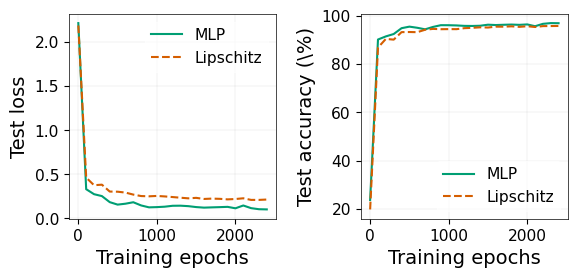

In [17]:
color_mlp = "#009E73"
color_lbdn = "#D55E00"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.plot(metrics_mlp["step"], metrics_mlp["test_loss"], color=color_mlp, label="MLP")
ax2.plot(metrics_mlp["step"], metrics_mlp["test_accuracy"], color=color_mlp, label="MLP")

ax1.plot(metrics_lbdn["step"], metrics_lbdn["test_loss"], "--", color=color_lbdn, label="Lipschitz")
ax2.plot(metrics_lbdn["step"], metrics_lbdn["test_accuracy"], "--", color=color_lbdn, label="Lipschitz")

ax1.set_xlabel("Training epochs")
ax2.set_xlabel("Training epochs")
ax1.set_ylabel("Test loss")
ax2.set_ylabel("Test accuracy (\%)")

ax1.legend()
ax2.legend()

plt.tight_layout()

As we can see, the Lipschtiz-bounded network and MLP achieve a similar final accuracy. Great. We can check a few test examples too to see how they look.

In [18]:
def plot_mnist_results(test_batch, pred, name):

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    for i, ax in enumerate(axs.flatten()):

        # Reshape image again for plotting
        label = test_batch['label'][i]
        image = test_batch['image'][i]
        image = jnp.reshape(image, (28, 28))

        # Plot the number
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}, Pred: {pred[i]}")
        ax.axis('off')
        fig.suptitle(name)
    plt.show()

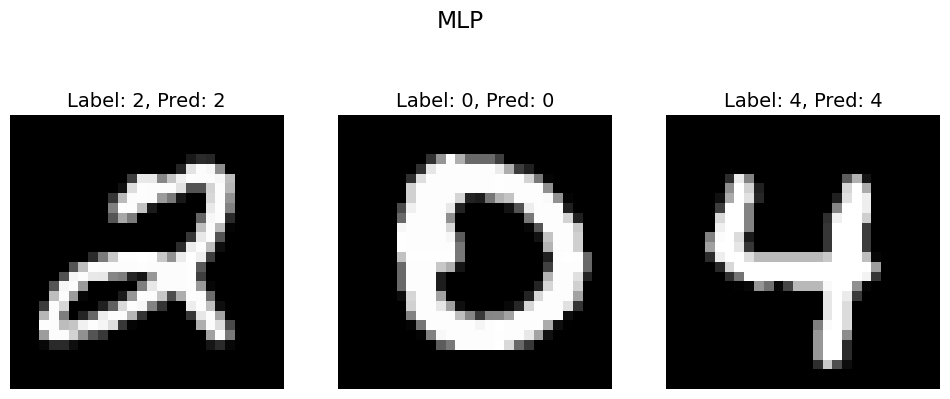

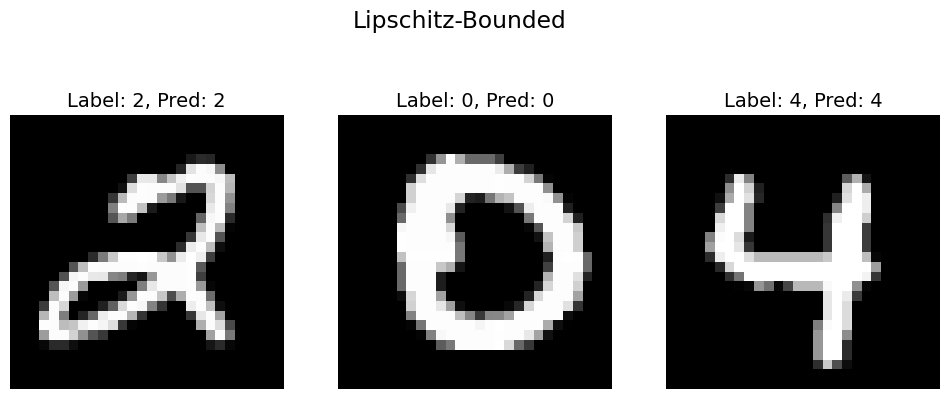

In [19]:
# Run the predictions
test_batch = test_ds.as_numpy_iterator().next()
pred_mlp = predict(model_mlp, params_mlp, test_batch)
pred_lbdn = predict(model_lbdn, params_lbdn, test_batch)

# Plot the predictions
plot_mnist_results(test_batch, pred_mlp, "MLP")
plot_mnist_results(test_batch, pred_lbdn, "Lipschitz-Bounded")

## 7. Testing Robustness with Adversarial Attacks

Now that we've trained the networks, let's test their robustness to targeted adversarial attacks. We'll choose our adversarial attacks for each image by performing gradient ascent on the original loss function! I.e: the attacks are optimised to make the classifiers as bad as possible. The function below does the following:
- Randomly initialises an adversarial attack with a $\ell_2$-norm of `attack_size` for each image.
- Adds the attack to the original images.
- Performs `max_iter` steps of gradient ascent on the loss function we used to train the classifiers to choose the worst-case attacks.

In [20]:
def pgd_attack(
    model,
    params,
    test_batch,
    attack_size=1,
    max_iter=500,
    learning_rate=0.01,
    seed=0
):

    # Edge case
    if attack_size == 0:
        return jnp.zeros(test_batch["image"].shape), test_batch

    # Define how to constrain attack size (l2 norm)
    def project_attack(attack, attack_size):
        attack = attack / jnp.linalg.norm(attack, axis=-1, keepdims=True)
        return attack_size * attack

    # Initialise an attack
    rng = jax.random.key(seed)
    rng, key1 = jax.random.split(rng)
    attack = jax.random.uniform(key1, test_batch["image"].shape)
    attack = (project_attack(attack, attack_size),)

    # Set up the optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(attack)

    # Loss function
    @jax.jit
    def loss_fn(attack, batch):
        attack = project_attack(attack[0], attack_size)
        attacked_image = batch['image'] + attack
        logits = model.apply(params, attacked_image)
        return -get_loss(logits, batch['label'])

    # A single attack step with projected gradient descent
    @jax.jit
    def attack_step(attack, opt_state, batch):
        grad_fn = jax.grad(loss_fn)
        grads = grad_fn(attack, batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        attack = optax.apply_updates(attack, updates)
        return attack, opt_state

    # Use gradient descent to estimate the Lipschitz bound
    for _ in range(max_iter):
        attack, opt_state = attack_step(attack, opt_state, test_batch)

    # Return the attack and the perturbed image
    attack = project_attack(attack[0], attack_size)
    attack_batch = {"image": test_batch["image"] + attack,
                      "label": test_batch["label"]}
    return attack, attack_batch

Let's use this function to compute the test accuracy of each model as a function of the attack size.

In [21]:
def attacked_test_error(model, params, test_batch, attack_size):
    _, attack_batch = pgd_attack(model, params, test_batch, attack_size)
    logits = model.apply(params, attack_batch['image'])
    labels = test_batch["label"]
    return 100 * jnp.mean(jnp.argmax(logits, axis=-1) == labels)

attack_sizes = jnp.arange(0, 3.1, 0.1)
acc_mlp = []
acc_lbdn = []
for a in attack_sizes:
    acc_mlp.append(attacked_test_error(model_mlp, params_mlp, test_batch, a))
    acc_lbdn.append(attacked_test_error(model_lbdn, params_lbdn, test_batch, a))

Plotting our results below reveals that the Lipschitz-bounded models are significantly more robust to $\ell_2$-optimal adversarial attacks than the unconstrained MLP models. This is the advantage of a Lipschitz bound. Even though we are optimising the attacks to be the worst possible for each image, the Lipschitz bound fundamentally constrains the sensitivity of the LBDN network so that the attacker **must** use larger attack sizes.

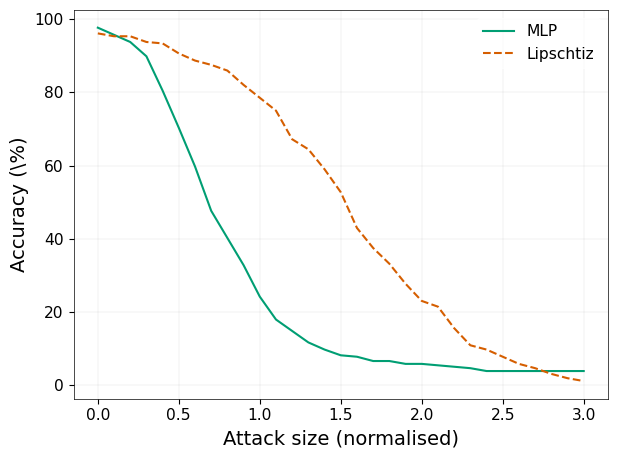

In [22]:
plt.plot(attack_sizes, acc_mlp, color=color_mlp, label="MLP")
plt.plot(attack_sizes, acc_lbdn, "--", color=color_lbdn, label="Lipschtiz")
plt.xlabel("Attack size (normalised)")
plt.ylabel("Accuracy (\%)")
plt.legend()
plt.tight_layout()

We can dig a little deeper here too. Let's take a look at what sort of attacks are required to reduce the MLP accuracy to 20%.

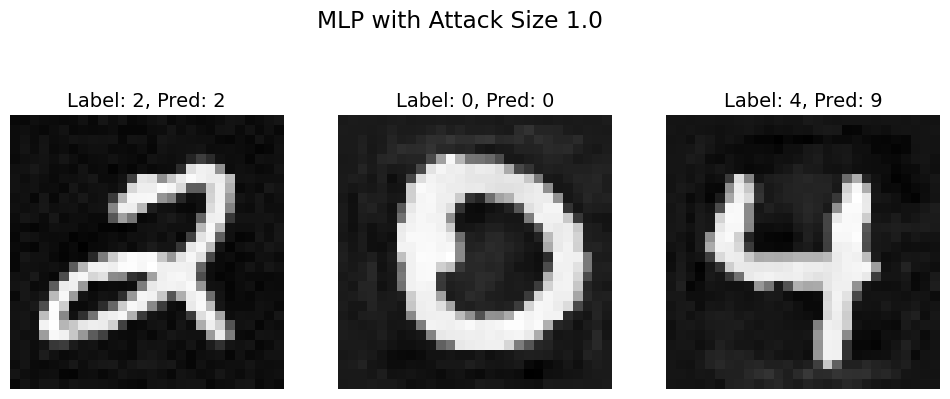

In [23]:
attack_size = 1.0
_, attack_batch_mlp = pgd_attack(model_mlp, params_mlp, test_batch, attack_size)
pred_mlp = predict(model_mlp, params_mlp, attack_batch_mlp)
plot_mnist_results(attack_batch_mlp, pred_mlp, "MLP with Attack Size 1.0")

Now let's have a look at the attacks required to reduce the Lipschitz-bounded networks to an accuracy of about 20%.

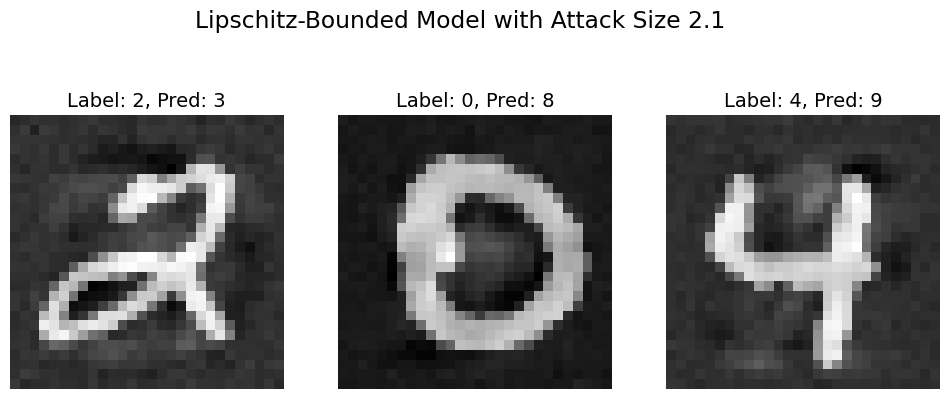

In [24]:
attack_size = 2.1
_, attack_batch_lbdn = pgd_attack(model_lbdn, params_lbdn, test_batch, attack_size)
pred_lbdn = predict(model_lbdn, params_lbdn, attack_batch_lbdn)
plot_mnist_results(attack_batch_lbdn, pred_lbdn, "Lipschitz-Bounded Model with Attack Size 2.1")

It's clear that the attacker actually has to start changing the numbers in a very structured way to fool the Lipschitz-bounded model. For example, it seems to be trying to turn the 4 into a 9 in the right panel of the image above.